In [10]:
!pip install requests beautifulsoup4 pandas selenium


Defaulting to user installation because normal site-packages is not writeable

DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB 1.3 MB/s eta 0:00:08
   ---------------------------------------- 0.1/9.5 MB 656.4 kB/s eta 0:00:15
   ---------------------------------------- 0.1/9.5 MB 751.6 kB/s eta 0:00:13
   ---------------------------------------- 0.1/9.5 MB 656.4 kB/s eta 0:00:15
    --------------------------------------- 0.2/9.5 MB 817.0 kB/s eta 0:00:12
    --------------------------------------- 0.2/9.5 MB 787.7 kB/s eta 0:00:12
   - -------------------------------------- 0.3/9.5 MB 785.2 kB/s eta 0:00:12
   - -------------------------------------- 0.3/9.5 MB 770.1 kB/s eta 0:00:13
   - -------------------------------------- 0.3/9.5 MB 811.9 kB/s eta 0:00:12
   - -------------------------------------- 0.4/9.5 MB 807.8 kB/s eta 0:00:12
   - -------------------------------------- 0.4/9.5 MB 833.5 kB/s eta 0:00:11
   -- -------

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


In [6]:
def scrape_gold_prices(url):
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    
    # Check if the request was successful
    if response.status_code != 200:
        print(f"Failed to fetch data from {url}, status code: {response.status_code}")
        return pd.DataFrame()  # Return an empty DataFrame in case of failure

    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the table with gold price data
    rows = soup.select('table.metal-history-table tbody tr')
    
    # Initialize a list to store the data
    data = []
    
    # Loop through all rows and extract the relevant columns
    for row in rows:
        # Extract the date and price data for each day
        columns = row.find_all('td')
        
        if columns:
            date = columns[0].text.strip()
            prices = [col.text.strip().replace('₨', '').replace(',', '') for col in columns[1:]]  # Remove currency symbol and commas
            data.append([date] + prices)  # Store the date and all price columns in the data list
    
    # Check if data is empty
    if not data:
        print(f"No data found while scraping {url}. Please check the website's structure.")
        return pd.DataFrame()  # Return an empty DataFrame if no data was found
    
    # Define column names
    column_names = ['Date', '24 Karat', '22 Karat', '18 Karat', '14 Karat', '10 Karat']
    
    # Convert to a DataFrame
    df = pd.DataFrame(data, columns=column_names)
    
    return df

# Example URL (replace with the actual URL for scraping)
gold_url = 'https://www.exchange-rates.org/precious-metals/gold-price/pakistan/2024'  # Use the correct URL

# Scrape the gold prices data
gold_data = scrape_gold_prices(gold_url)
gold_data.to_csv("gold_prices.csv", index=False)
# Check the results
print(gold_data.head())  # Print the first few rows of the DataFrame


    Date 24 Karat 22 Karat 18 Karat 14 Karat 10 Karat
0  1 Jan   576240   528220   432180   336140   240100
1  2 Jan   580658   532270   435493   338717   241941
2  3 Jan   575703   527728   431778   335827   239876
3  4 Jan   575569   527605   431677   335749   239820
4  5 Jan   575829   527844   431872   335901   239929


In [9]:
def scrape_usd_to_pkr(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table that contains the data
    table = soup.find('table', class_='history-rates-data')
    
    data = []

    # Extract rows of the table
    rows = table.find_all('tr')[2:]  # Skip the first two rows (month header and column header)

    for row in rows:
        columns = row.find_all('td')
        if len(columns) > 1:
            # Extract date and exchange rate (USD to PKR)
            date = columns[0].get_text(strip=True)
            rate = columns[1].get_text(strip=True).split(" = ")[-1].replace(" PKR", "")
            data.append([date, rate])

    # Convert the data to a DataFrame
    df = pd.DataFrame(data, columns=["Date", "USD to PKR"])
    
    return df

# Example URL for the USD to PKR historical data
usd_to_pkr_url = "https://www.exchange-rates.org/exchange-rate-history/usd-pkr-2024"
usd_to_pkr_data = scrape_usd_to_pkr(usd_to_pkr_url)

# Saving to CSV
usd_to_pkr_data.to_csv("usd_to_pkr_2024.csv", index=False)

# Display the data (optional)
print(usd_to_pkr_data)

                            Date                  USD to PKR
0        January 1, 20242024-1-1  1 USD =278.981 USD =278.98
1        January 2, 20242024-1-2  1 USD =281.951 USD =281.95
2        January 3, 20242024-1-3  1 USD =281.831 USD =281.83
3        January 4, 20242024-1-4  1 USD =281.711 USD =281.71
4        January 5, 20242024-1-5  1 USD =281.501 USD =281.50
..                           ...                         ...
257  December 25, 20242024-12-25  1 USD =277.961 USD =277.96
258  December 26, 20242024-12-26  1 USD =277.961 USD =277.96
259  December 27, 20242024-12-27  1 USD =278.391 USD =278.39
260  December 30, 20242024-12-30  1 USD =278.301 USD =278.30
261  December 31, 20242024-12-31  1 USD =278.521 USD =278.52

[262 rows x 2 columns]


In [19]:
import time
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

# Set up the web driver (make sure the path to ChromeDriver is correct)
driver = webdriver.Chrome()

# URL of the page to scrape
url = "https://www.lbma.org.uk/prices-and-data/precious-metal-prices#/table"

# Open the URL in the browser
driver.get(url)

# Wait for at least 20 seconds before starting scraping
time.sleep(20)

# Wait for the table to load (adjust the timeout as necessary)
WebDriverWait(driver, 25).until(
    EC.presence_of_element_located((By.CLASS_NAME, "pepper-responsive-table"))
)

# Retrieve the page's source code after JavaScript execution
html_content = driver.page_source

# Use BeautifulSoup to parse the page source
soup = BeautifulSoup(html_content, 'html.parser')

# Find the table with the class 'pepper-responsive-table'
table = soup.find('table')

if table:
    # Extract the headers (USD $, GBP £, EUR €)
    headers = ['Date', 'USD AM', 'USD PM', 'GBP AM', 'GBP PM', 'EUR AM', 'EUR PM']

    # Extract the table rows containing the data
    data = []
    rows = table.find_all('tr')[2:]  # Skip the first two header rows
    for row in rows:
        columns = row.find_all('td')
        if len(columns) > 0:  # Skip rows without data
            row_data = [col.get_text(strip=True) for col in columns]
            data.append(row_data)

    # Create a DataFrame to organize the data
    df = pd.DataFrame(data, columns=headers)
    print(df)

    # Save the data to a CSV file
    df.to_csv("precious_metal_prices_2024.csv", index=False)
else:
    print("Table not found!")

# Close the browser
driver.quit()


           Date   USD AM   USD PM   GBP AM   GBP PM   EUR AM   EUR PM
0    31-12-2024  2610.85           2083.20           2508.24         
1    30-12-2024  2610.30  2609.10  2073.88  2078.93  2501.45  2508.39
2    27-12-2024  2625.55  2615.95  2097.55  2081.25  2520.27  2509.48
3    24-12-2024  2613.75           2086.30           2514.95         
4    23-12-2024  2620.55  2613.80  2086.22  2086.60  2519.40  2515.78
..          ...      ...      ...      ...      ...      ...      ...
249  08-01-2024  2028.00  2025.10  1596.85  1591.53  1854.00  1848.11
250  05-01-2024  2037.70  2056.35  1610.39  1613.41  1868.77  1872.10
251  04-01-2024  2049.05  2039.55  1610.35  1608.39  1869.14  1863.13
252  03-01-2024  2054.05  2042.10  1626.60  1615.30  1879.04  1869.95
253  02-01-2024  2074.90  2067.55  1632.53  1637.29  1885.46  1886.43

[254 rows x 7 columns]


# Code for gold prices dataset.

In [61]:
gold_prices = pd.read_csv('gold_prices.csv')  

gold_prices['Date'] = pd.to_datetime(gold_prices['Date'] + '-2024', format='%d-%b-%Y').dt.strftime('%Y-%m-%d')

# Save the converted dataset
gold_prices.to_csv('gold_converted.csv', index=False)
print("First dataset converted successfully.")


First dataset converted successfully.


# Code for Global Gold Price Dataset

In [60]:
from datetime import datetime

def convert_to_mm_dd_yyyy(date_str):
    for fmt in ("%m/%d/%Y", "%d-%m-%Y"):
        try:
            date_obj = datetime.strptime(date_str, fmt)
            return date_obj.strftime("%m/%d/%Y")
        except ValueError:
            continue
    return date_str  # Return the original if no match

# Load the dataset
data = pd.read_csv('precious_metal_prices_2024.csv')  

# Reversing the order of the rows
data_reversed = data.iloc[::-1]

# Reseting the index as this dataset started from 31 december
data_reversed = data_reversed.reset_index(drop=True)

# Converting the dates in the first column 
data_reversed['Date'] = data_reversed['Date'].apply(convert_to_mm_dd_yyyy)

# Saving the modified DataFrame with updated dates to a new CSV file
data_reversed.to_csv('precious_metal_prices_2024_final.csv', index=False)

print("Dates have been successfully converted and saved to 'precious_metal_prices_2024_reversed_date_fixed.csv'")


Dates have been successfully converted and saved to 'precious_metal_prices_2024_reversed_date_fixed.csv'


# Code for Second currency exchange datasets

In [62]:
usd_to_pkr = pd.read_csv('usd_to_pkr_2024.csv')  # Replace with your file path

# Extract the first part of the 'Date' column (before the extra appended date)
usd_to_pkr['Date'] = usd_to_pkr['Date'].str.split('2024-').str[0].str.strip()

# Convert the cleaned 'Date' column to the 'YYYY-MM-DD' format
usd_to_pkr['Date'] = pd.to_datetime(usd_to_pkr['Date'], format='%B %d, %Y').dt.strftime('%Y-%m-%d')

# Save the converted usd_to_pkrset
usd_to_pkr.to_csv('usd_to_pkr_2024_converted.csv', index=False)
print("Dataset converted successfully.")


Dataset converted successfully.


# Filing missing values

In [63]:
df = pd.read_csv('precious_metal_prices_2024_final.csv')

# Converting the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Creating a full date range for only business days within the range of the dataset
full_date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='B')

# Reindexing the DataFrame to include all dates in the range
df = df.set_index('Date').reindex(full_date_range).reset_index()

# Renaming the index column to 'Date'
df.columns = ['Date', 'USD AM', 'USD PM', 'GBP AM', 'GBP PM', 'EUR AM', 'EUR PM']

# Forwarding fill missing values, then backward fill remaining gaps
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

df.to_csv('precious_metal_prices_2024_final_all_dates_included.csv', index=False)

# Display the resulting DataFrame
print(df)


          Date   USD AM   USD PM   GBP AM   GBP PM   EUR AM   EUR PM
0   2024-01-02  2074.90  2067.55  1632.53  1637.29  1885.46  1886.43
1   2024-01-03  2054.05  2042.10  1626.60  1615.30  1879.04  1869.95
2   2024-01-04  2049.05  2039.55  1610.35  1608.39  1869.14  1863.13
3   2024-01-05  2037.70  2056.35  1610.39  1613.41  1868.77  1872.10
4   2024-01-08  2028.00  2025.10  1596.85  1591.53  1854.00  1848.11
..         ...      ...      ...      ...      ...      ...      ...
256 2024-12-25  2613.75  2613.80  2086.30  2086.60  2514.95  2515.78
257 2024-12-26  2613.75  2613.80  2086.30  2086.60  2514.95  2515.78
258 2024-12-27  2625.55  2615.95  2097.55  2081.25  2520.27  2509.48
259 2024-12-30  2610.30  2609.10  2073.88  2078.93  2501.45  2508.39
260 2024-12-31  2610.85  2609.10  2083.20  2078.93  2508.24  2508.39

[261 rows x 7 columns]


C:\Users\Syed Burhan Ahmed\AppData\Local\Temp\ipykernel_23420\3066419450.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\Syed Burhan Ahmed\AppData\Local\Temp\ipykernel_23420\3066419450.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [58]:
df = pd.read_csv('Petrol Price.csv')

# Converting the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create a full date range for business days within the range of the dataset
full_date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='B')

# Reindex the DataFrame to include all dates in the range
df = df.set_index('Date').reindex(full_date_range).reset_index()

# Rename the index column to 'Date'
df.columns = ['Date', 'Petrol Price']

# Forward fill missing values, then backward fill remaining gaps
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Save the completed dataset back to a CSV file (optional)
# Replace 'output_file.csv' with your desired output file name
df.to_csv('Final_Petrol_Price.csv', index=False)

# Display the resulting DataFrame
print(df)


          Date  Petrol Price
0   2024-01-01        267.34
1   2024-01-02        267.34
2   2024-01-03        267.34
3   2024-01-04        267.34
4   2024-01-05        267.34
..         ...           ...
246 2024-12-10        248.38
247 2024-12-11        248.38
248 2024-12-12        248.38
249 2024-12-13        248.38
250 2024-12-16        252.10

[251 rows x 2 columns]


C:\Users\Syed Burhan Ahmed\AppData\Local\Temp\ipykernel_23420\2688307351.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\Syed Burhan Ahmed\AppData\Local\Temp\ipykernel_23420\2688307351.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


# Combining Dataset

In [57]:

file1 = 'usd_to_pkr_2024_converted.csv'
file2 = 'precious_metal_prices_2024_final_all_dates_included.csv'
file3 = 'gold_converted.csv'
file4 = 'Final_Petrol_Price.csv'
# Load the datasets
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)
df4 = pd.read_csv(file4)

# Ensure the 'Date' column is in datetime format for all datasets
df1['Date'] = pd.to_datetime(df1['Date'])
df2['Date'] = pd.to_datetime(df2['Date'])
df3['Date'] = pd.to_datetime(df3['Date'])
df4['Date'] = pd.to_datetime(df4['Date'])

# Merge the datasets on the 'Date' column
combined_df = pd.merge(df1, df2, on='Date', how='outer')
combined_df = pd.merge(combined_df, df3, on='Date', how='outer')
combined_df = pd.merge(combined_df, df4, on='Date', how='outer')

# Sort by Date to ensure proper ordering
combined_df = combined_df.sort_values(by='Date').reset_index(drop=True)

# Save the combined dataset to a CSV file
output_file = 'gold_price_prediction_2024_dataset.csv'
combined_df.to_csv(output_file, index=False)

# Display a message
print(f"Combined dataset saved to {output_file}")


Combined dataset saved to gold_price_prediction_2024_dataset.csv


# Cleaning values

In [59]:

file = 'gold_price_prediction_2024_dataset.csv'  
df = pd.read_csv(file)


column_name = 'USD to PKR'


df[column_name] = df[column_name].str.extract(r'=\s*([\d.]+)$')


df.to_csv('gold_price_prediction_dataset.csv', index=False)


print(df)


           Date USD to PKR  Global Gold Price(USD)   USD PM   GBP AM   GBP PM  \
0      1/1/2024     278.98                 2074.90  2067.55  1632.53  1637.29   
1      1/2/2024     281.95                 2074.90  2067.55  1632.53  1637.29   
2      1/3/2024     281.83                 2054.05  2042.10  1626.60  1615.30   
3      1/4/2024     281.71                 2049.05  2039.55  1610.35  1608.39   
4      1/5/2024     281.50                 2037.70  2056.35  1610.39  1613.41   
..          ...        ...                     ...      ...      ...      ...   
257  12/25/2024     277.96                 2613.75  2613.80  2086.30  2086.60   
258  12/26/2024     277.96                 2613.75  2613.80  2086.30  2086.60   
259  12/27/2024     278.39                 2625.55  2615.95  2097.55  2081.25   
260  12/30/2024     278.30                 2610.30  2609.10  2073.88  2078.93   
261  12/31/2024     278.52                 2610.85  2609.10  2083.20  2078.93   

      EUR AM   EUR PM  24 K

In [67]:
df = pd.read_csv('gold_price_prediction_dataset.csv')

columns_to_convert = ['Global Gold Price(USD)', 'USD PM', 'GBP AM', 'GBP PM', 'EUR AM', 'EUR PM']

troy_to_regular_conversion = 1.09714

for column in columns_to_convert:
    df[column] = df[column] / troy_to_regular_conversion

# Save the modified DataFrame to a new CSV file
df.to_csv('gold_price_prediction_dataset_final.csv', index=False)

print("Gold prices have been successfully converted to regular ounces and saved to 'gold_price_prediction_dataset_final.csv'.")


Gold prices have been successfully converted to regular ounces and saved to 'gold_price_prediction_dataset_final.csv'.


# Now Dataset is ready to be trained

In [69]:
import numpy as np
#pandas already imported
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
df = pd.read_csv('gold_price_prediction_dataset_final.csv')
df

,Date,USD to PKR,Global Gold Price(USD),USD PM,GBP AM,GBP PM,EUR AM,EUR PM,24 Karat,22 Karat,18 Karat,14 Karat,10 Karat,Petrol Price
0,1/1/2024,278.98,1891.189821,1884.490585,1487.986948,1492.325501,1718.522704,1719.406821,576240,528220,432180,336140,240100,267.34
1,1/2/2024,281.95,1891.189821,1884.490585,1487.986948,1492.325501,1718.522704,1719.406821,580658,532270,435493,338717,241941,267.34
2,1/3/2024,281.83,1872.185865,1861.293910,1482.581986,1472.282480,1712.671127,1704.385949,575703,527728,431778,335827,239876,267.34
3,1/4/2024,281.71,1867.628562,1858.969685,1467.770749,1465.984286,1703.647666,1698.169787,575569,527605,431677,335749,239820,267.34
4,1/5/2024,281.50,1857.283483,1874.282225,1467.807208,1470.559819,1703.310425,1706.345589,575829,527844,431872,335901,239929,267.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,12/25/2024,277.96,2382.330423,2382.375996,1901.580473,1901.853911,2292.278105,2293.034617,728204,667520,546153,424785,303418,252.10
258,12/26/2024,277.96,2382.330423,2382.375996,1901.580473,1901.853911,2292.278105,2293.034617,731770,670789,548827,426866,304904,252.10
259,12/27/2024,278.39,2393.085659,2384.335636,1911.834406,1896.977596,2297.127076,2287.292415,729883,669059,547412,425765,304118,252.10
260,12/30/2024,278.30,2379.185883,2378.092130,1890.260131,1894.863007,2279.973385,2286.298923,724878,664472,543659,422846,302033,252.10


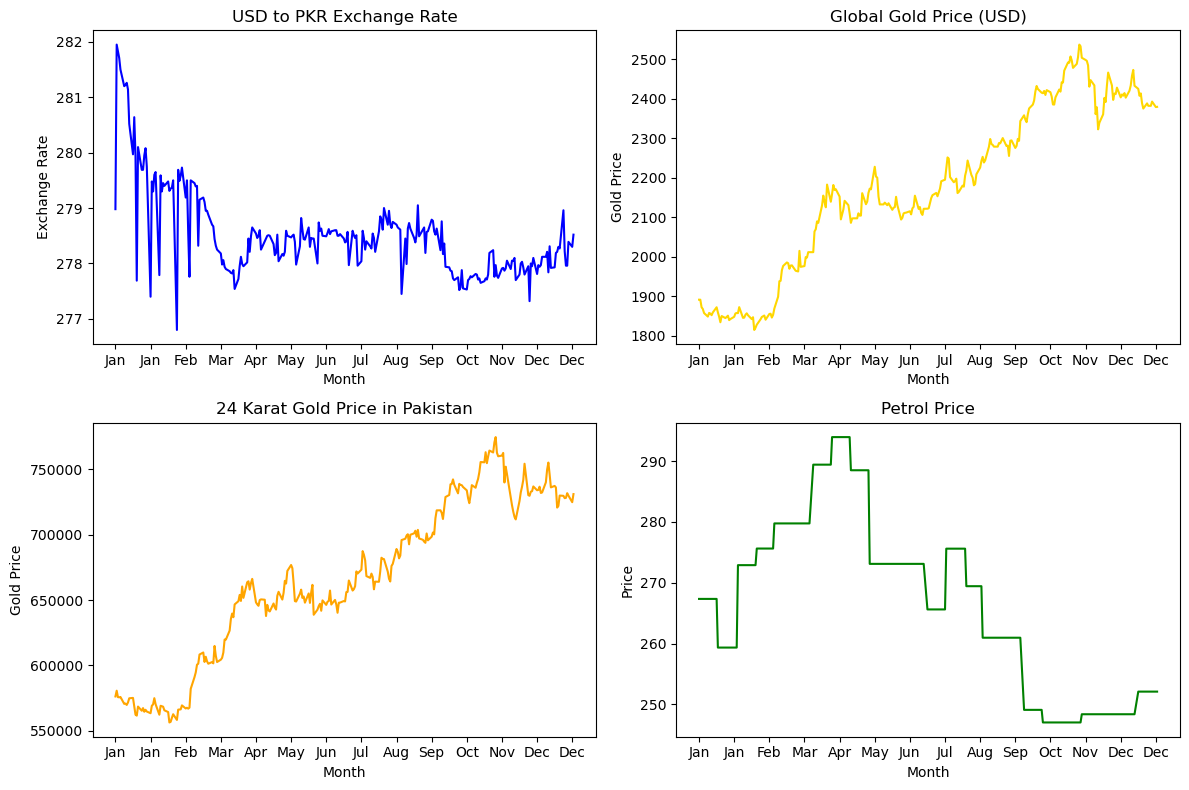

In [90]:
date = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Set figure size
plt.figure(figsize=(12, 8))

# Subplot 1: USD to PKR
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
plt.plot(date, df['USD to PKR'], label='USD to PKR', color='blue')
plt.title('USD to PKR Exchange Rate')
plt.xlabel('Month')
plt.ylabel('Exchange Rate')
plt.xticks(ticks=date[::20], labels=date[::20].dt.strftime('%b'))  # Show month names

# Subplot 2: Global Gold Price (USD)
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
plt.plot(date, df['Global Gold Price(USD)'], label='Global Gold Price', color='gold')
plt.title('Global Gold Price (USD)')
plt.xlabel('Month')
plt.ylabel('Gold Price')
plt.xticks(ticks=date[::20], labels=date[::20].dt.strftime('%b'))  # Show month names

# Subplot 3: 24 Karat Gold Price
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, 3rd subplot
plt.plot(date, df['24 Karat'], label='24 Karat Gold Price', color='orange')
plt.title('24 Karat Gold Price in Pakistan')
plt.xlabel('Month')
plt.ylabel('Gold Price')
plt.xticks(ticks=date[::20], labels=date[::20].dt.strftime('%b'))  # Show month names

# Subplot 4: Petrol Price
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, 4th subplot
plt.plot(date, df['Petrol Price'], label='Petrol Price', color='green')
plt.title('Petrol Price')
plt.xlabel('Month')
plt.ylabel('Price')
plt.xticks(ticks=date[::20], labels=date[::20].dt.strftime('%b'))  # Show month names

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    262 non-null    object 
 1   USD to PKR              262 non-null    float64
 2   Global Gold Price(USD)  262 non-null    float64
 3   USD PM                  262 non-null    float64
 4   GBP AM                  262 non-null    float64
 5   GBP PM                  262 non-null    float64
 6   EUR AM                  262 non-null    float64
 7   EUR PM                  262 non-null    float64
 8   24 Karat                262 non-null    int64  
 9   22 Karat                262 non-null    int64  
 10  18 Karat                262 non-null    int64  
 11  14 Karat                262 non-null    int64  
 12  10 Karat                262 non-null    int64  
 13  Petrol Price            262 non-null    float64
dtypes: float64(8), int64(5), object(1)
memory 

In [92]:
df.describe()

,USD to PKR,Global Gold Price(USD),USD PM,GBP AM,GBP PM,EUR AM,EUR PM,24 Karat,22 Karat,18 Karat,14 Karat,10 Karat,Petrol Price
count,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.00000,262.000000,262.000000,262.000000
mean,278.523359,2176.168969,2175.738287,1701.956141,1701.736033,2012.132620,2011.974576,665324.244275,609880.568702,498993.20229,388105.839695,277218.438931,266.479504
std,0.797920,204.393942,203.887252,148.909192,148.396872,196.749253,196.310915,61017.970936,55933.112411,45763.50117,35593.801352,25424.132752,14.231418
min,276.800000,1814.535975,1809.340649,1444.346209,1441.867036,1683.832510,1684.479647,556341.000000,509979.000000,417255.00000,324532.000000,231809.000000,247.030000
25%,277.970000,2027.202545,2029.720455,1606.634067,1608.997029,1878.921560,1881.118180,628850.750000,576446.500000,471638.00000,366829.500000,262021.250000,252.100000
50%,278.450000,2166.724393,2170.370235,1703.743369,1703.643108,2003.203784,2004.666679,663296.000000,608021.500000,497472.00000,386923.000000,276373.500000,267.340000
75%,278.665000,2379.060557,2377.579434,1818.161310,1819.284686,2176.162568,2178.386532,724689.500000,664299.000000,543517.50000,422736.000000,301954.250000,275.600000
max,281.950000,2537.461035,2531.855552,1971.835864,1962.374902,2367.974917,2360.546512,774681.000000,710124.000000,581011.00000,451897.000000,322784.000000,293.940000


In [95]:
df.dtypes

Date                       object
USD to PKR                float64
Global Gold Price(USD)    float64
USD PM                    float64
GBP AM                    float64
GBP PM                    float64
EUR AM                    float64
EUR PM                    float64
24 Karat                    int64
22 Karat                    int64
18 Karat                    int64
14 Karat                    int64
10 Karat                    int64
Petrol Price              float64
dtype: object

In [96]:
df.duplicated().sum()

0

# Dropping Irrelevant Columns

In [98]:
df.drop(columns = ['USD PM','GBP AM','GBP PM','EUR AM','EUR PM','22 Karat','18 Karat','14 Karat','10 Karat'], inplace = True)
df

,Date,USD to PKR,Global Gold Price(USD),24 Karat,Petrol Price
0,1/1/2024,278.98,1891.189821,576240,267.34
1,1/2/2024,281.95,1891.189821,580658,267.34
2,1/3/2024,281.83,1872.185865,575703,267.34
3,1/4/2024,281.71,1867.628562,575569,267.34
4,1/5/2024,281.50,1857.283483,575829,267.34
...,...,...,...,...,...
257,12/25/2024,277.96,2382.330423,728204,252.10
258,12/26/2024,277.96,2382.330423,731770,252.10
259,12/27/2024,278.39,2393.085659,729883,252.10
260,12/30/2024,278.30,2379.185883,724878,252.10


In [99]:
df.drop(columns = ['Date'],inplace = True)
df

,USD to PKR,Global Gold Price(USD),24 Karat,Petrol Price
0,278.98,1891.189821,576240,267.34
1,281.95,1891.189821,580658,267.34
2,281.83,1872.185865,575703,267.34
3,281.71,1867.628562,575569,267.34
4,281.50,1857.283483,575829,267.34
...,...,...,...,...
257,277.96,2382.330423,728204,252.10
258,277.96,2382.330423,731770,252.10
259,278.39,2393.085659,729883,252.10
260,278.30,2379.185883,724878,252.10


In [100]:
df.corr()

,USD to PKR,Global Gold Price(USD),24 Karat,Petrol Price
USD to PKR,1.000000,-0.656729,-0.649995,0.219650
Global Gold Price(USD),-0.656729,1.000000,0.996594,-0.639906
24 Karat,-0.649995,0.996594,1.000000,-0.636346
Petrol Price,0.219650,-0.639906,-0.636346,1.000000


In [101]:
X = df.iloc[:,[0,1,3]].values
X

array([[ 278.98      , 1891.18982081,  267.34      ],
       [ 281.95      , 1891.18982081,  267.34      ],
       [ 281.83      , 1872.18586507,  267.34      ],
       [ 281.71      , 1867.62856153,  267.34      ],
       [ 281.5       , 1857.28348251,  267.34      ],
       [ 281.2       , 1848.44231365,  267.34      ],
       [ 281.22      , 1857.69363983,  267.34      ],
       [ 281.26      , 1855.96186448,  267.34      ],
       [ 281.14      , 1851.95143737,  267.34      ],
       [ 280.52      , 1858.96968482,  267.34      ],
       [ 279.97      , 1872.00357293,  267.34      ],
       [ 280.64      , 1859.15197696,  259.34      ],
       [ 279.94      , 1848.03215633,  259.34      ],
       [ 277.69      , 1834.04123448,  259.34      ],
       [ 280.1       , 1849.80950471,  259.34      ],
       [ 279.69      , 1844.70532475,  259.34      ],
       [ 279.69      , 1847.39413384,  259.34      ],
       [ 279.95      , 1850.72096542,  259.34      ],
       [ 280.08      , 1839.

In [102]:
y = df.iloc[:,2].values
y

array([576240, 580658, 575703, 575569, 575829, 570563, 570767, 569754,
       571620, 574826, 575115, 568735, 562266, 561572, 568500, 565308,
       567318, 564540, 566025, 564695, 563397, 569078, 570141, 574930,
       570319, 562263, 569094, 568762, 568421, 565644, 564304, 556341,
       556783, 559904, 562634, 558275, 566141, 566257, 566347, 569403,
       567040, 567593, 566914, 567637, 582073, 590986, 594601, 600533,
       601299, 608302, 609869, 602620, 606611, 603114, 601283, 602542,
       601568, 614885, 607283, 602586, 604375, 605773, 609851, 619816,
       619718, 626616, 635555, 639670, 636848, 646647, 649143, 653959,
       649335, 660365, 651669, 663618, 664352, 657997, 662974, 666212,
       648229, 646734, 645602, 649985, 650516, 650241, 637797, 646298,
       642060, 641262, 647374, 644274, 642715, 653273, 656301, 650372,
       655525, 664711, 662607, 672283, 676817, 674369, 662948, 649204,
       648864, 654841, 657974, 651624, 652722, 647997, 655057, 647840,
      

In [103]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[ 5.73384904e-01, -1.39693262e+00,  6.05802652e-02],
       [ 4.30268722e+00, -1.39693262e+00,  6.05802652e-02],
       [ 4.15200834e+00, -1.49008766e+00,  6.05802652e-02],
       [ 4.00132946e+00, -1.51242700e+00,  6.05802652e-02],
       [ 3.73764141e+00, -1.56313730e+00,  6.05802652e-02],
       [ 3.36094421e+00, -1.60647562e+00,  6.05802652e-02],
       [ 3.38605736e+00, -1.56112676e+00,  6.05802652e-02],
       [ 3.43628365e+00, -1.56961571e+00,  6.05802652e-02],
       [ 3.28560477e+00, -1.58927433e+00,  6.05802652e-02],
       [ 2.50709722e+00, -1.55487175e+00,  6.05802652e-02],
       [ 1.81648568e+00, -1.49098124e+00,  6.05802652e-02],
       [ 2.65777610e+00, -1.55397817e+00, -5.02632136e-01],
       [ 1.77881596e+00, -1.60848616e+00, -5.02632136e-01],
       [-1.04641307e+00, -1.67706793e+00, -5.02632136e-01],
       [ 1.97972113e+00, -1.59977382e+00, -5.02632136e-01],
       [ 1.46490162e+00, -1.62479388e+00, -5.02632136e-01],
       [ 1.46490162e+00, -1.61161367e+00

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [109]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [126]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf'),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}



In [127]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)  
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Mean Absolute Error": mae,
        "R2 Score": r2
    }


In [128]:
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Mean Squared Error: {metrics['Mean Squared Error']:.2f}")
    print(f"  Root Mean Squared Error: {metrics['Root Mean Squared Error']:.2f}")
    print(f"  Mean Absolute Error: {metrics['Mean Absolute Error']:.2f}")
    print(f"  R2 Score: {metrics['R2 Score']:.2f}")
    print()

Linear Regression:
  Mean Squared Error: 25593160.31
  Root Mean Squared Error: 5058.97
  Mean Absolute Error: 3841.03
  R2 Score: 0.99

Decision Tree:
  Mean Squared Error: 63209396.02
  Root Mean Squared Error: 7950.43
  Mean Absolute Error: 6014.02
  R2 Score: 0.98

Random Forest:
  Mean Squared Error: 35847199.69
  Root Mean Squared Error: 5987.25
  Mean Absolute Error: 4642.35
  R2 Score: 0.99

Support Vector Regressor:
  Mean Squared Error: 4107234278.37
  Root Mean Squared Error: 64087.71
  Mean Absolute Error: 53342.95
  R2 Score: -0.00

Gradient Boosting:
  Mean Squared Error: 38877597.73
  Root Mean Squared Error: 6235.19
  Mean Absolute Error: 4829.03
  R2 Score: 0.99



# As we can se Linear Regression Performs the best

In [129]:
results_comparison = pd.DataFrame(results)
results_comparison

,Linear Regression,Decision Tree,Random Forest,Support Vector Regressor,Gradient Boosting
Mean Squared Error,2.559316e+07,6.320940e+07,3.584720e+07,4.107234e+09,3.887760e+07
Root Mean Squared Error,5.058968e+03,7.950434e+03,5.987253e+03,6.408771e+04,6.235190e+03
Mean Absolute Error,3.841025e+03,6.014019e+03,4.642348e+03,5.334295e+04,4.829029e+03
R2 Score,9.937378e-01,9.845339e-01,9.912289e-01,-4.962158e-03,9.904874e-01


In [135]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [136]:
y_pred = lr.predict(X_test)

In [137]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  
r2 = r2_score(y_test, y_pred)

In [138]:
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error: 25593160.307941575
Root Mean Squared Error: 5058.968304698259
Mean Absolute Error: 3841.0252290588983
R2 Score: 0.9937378401477669


In [139]:
import joblib

joblib.dump(lr, 'linear_regression_model.pkl')

['linear_regression_model.pkl']